In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from util_data import *
from amorgibbs_v import *
from smc_v import *
from util_plots import *
from torch.distributions.dirichlet import Dirichlet
import sys
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 0.5.0a0+3bb8c5e cuda: True


In [2]:
## Dataset parameters
num_series = 1
## range of length of tracjectories, need to be positive integers
T_min = 30
T_max = 50
K = 4
D = 2
dt = 10
Boundary = 30
noise_ratio = 0.5

## Model Parameters
num_particles_rws = 50
mcmc_steps = 3
num_particles_smc = 50
NUM_HIDDEN = 128
NUM_LATENTS = K*K
NUM_OBS = 2 * K

NUM_EPOCHS = 1000
LEARNING_RATE = 1e-3
CUDA = False
RESTORE = False
PATH_ENC = "experiment/enc-%drws-%dmcmc-%dsmc-enc" % (num_particles_rws, mcmc_steps, num_particles_smc)

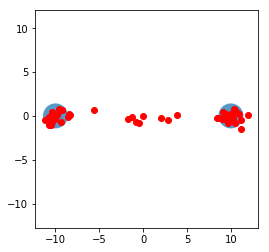

In [3]:
T_sample = 50
noise_cov = np.array([[1, 0], [0, 1]]) * noise_ratio        # Zs, log_weights, log_normalizers = csmc_hmm_v(Z_ret, Pi, A_samples, mu_ks, cov_ks, Y, T, D, K, num_particles_smc, num_particles_rws)
        # Z_ret = resampling_smc_v(Zs, log_weights, num_particles_rws)
        # Z_ret_pair = torch.cat((Z_ret[:, :T-1, :].unsqueeze(1), Z_ret[:, 1:, :].unsqueeze(1)), 1)o
init_v = np.random.random(2) * np.random.choice([-1,1], size=2)
v_norm = ((init_v ** 2 ).sum()) ** 0.5 ## compute norm for each initial velocity
init_v = init_v / v_norm * dt ## to make the velocity lying on a circle
STATE, Disp, A_true, Zs_true = generate_seq(T_sample, dt, Boundary, init_v, noise_cov)
## true global variables
cov_true = np.tile(noise_cov, (K, 1, 1))
dirs = np.array([[1, 1], [1, -1], [-1, -1], [-1, 1]])
mu_true = np.tile(np.absolute(init_v), (K, 1)) * dirs
plot_clusters(Disp, mu_true, cov_true, K)

In [4]:
class Encoder(nn.Module):
    def __init__(self, num_obs=NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU())
        self.latent_dir = nn.Sequential(
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs):
        A_samples = torch.zeros((K, K))
        hidden = self.enc_hidden(obs)
        latents_dirs = torch.exp(self.latent_dir(hidden)).sum(0).view(K, K)
        for k in range(K):
            A_samples[k] = Dirichlet(latents_dirs[k]).sample()
        return latents_dirs, A_samples

In [5]:
def initialize():
    enc = Encoder()
    if CUDA:
        enc.cuda()
    optimizer =  torch.optim.Adam(list(enc.parameters()),lr=LEARNING_RATE)    
    return enc, optimizer
enc, optimizer = initialize()

In [6]:
KLs = []
EUBOs = []
log_qs = []
ESSs = []

for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    optimizer.zero_grad()
    alpha_trans_0 = initial_trans_prior(K)
    init_v = init_velocity(dt)
    T = np.random.randint(T_min, T_max)
    mu_ks, cov_ks, Pi, Y, A_true, Zs_true = generate_seq_T(T, K, dt, Boundary, init_v, noise_cov)
    enc, eubo, kl, ess, latents_dirs, Z_ret, loss_infer = rws_v(enc, alpha_trans_0, Pi, mu_ks, cov_ks, Y, T, D, K, num_particles_rws, num_particles_smc, mcmc_steps)
    loss_infer.backward()
    KLs.append(kl.item())
    EUBOs.append(eubo.item())
    ESSs.append(ess)
#     log_qs.append(loss_infer.item())
    optimizer.step()
    time_end = time.time()
    print('epoch : %d, eubo : %f, KL : %f (%ds)' % (epoch, eubo, kl, time_end - time_start))

epoch : 0, eubo : 193.520630, KL : 590.040588 (11s)
epoch : 1, eubo : 268.137726, KL : 503.848053 (11s)
epoch : 2, eubo : 223.998947, KL : 489.563141 (11s)
epoch : 3, eubo : 132.009827, KL : 645.747437 (14s)
epoch : 4, eubo : 172.967300, KL : 586.534729 (13s)
epoch : 5, eubo : 236.288147, KL : 529.841064 (14s)
epoch : 6, eubo : 152.260284, KL : 509.899933 (12s)
epoch : 7, eubo : 205.573746, KL : 200.039810 (8s)
epoch : 8, eubo : 181.064865, KL : 294.324341 (8s)
epoch : 9, eubo : 214.229126, KL : 331.468140 (14s)
epoch : 10, eubo : 170.213882, KL : 433.087433 (11s)
epoch : 11, eubo : 101.747063, KL : 362.864502 (8s)
epoch : 12, eubo : -43.905365, KL : 521.513916 (12s)
epoch : 13, eubo : 58.108288, KL : 497.679504 (13s)
epoch : 14, eubo : 316.616760, KL : 545.678162 (14s)
epoch : 15, eubo : 192.044922, KL : 542.569092 (12s)
epoch : 16, eubo : 164.170914, KL : 364.279968 (8s)
epoch : 17, eubo : 96.403015, KL : 435.343414 (10s)
epoch : 18, eubo : 113.397392, KL : 364.126434 (9s)
epoch : 19

variational : 
tensor([[190.8548,  34.3187,  11.7786,  15.7313],
        [ 30.7193, 194.0605,  12.5118,  19.1730],
        [ 10.7414,  14.8290, 163.8736,  16.6619],
        [ 21.5444,  28.2500,  25.1001,  84.2295]], grad_fn=<ViewBackward>)
conjugate posterior :
tensor([[16.,  1.,  1.,  3.],
        [ 1., 10.,  2.,  1.],
        [ 2.,  2., 12.,  2.],
        [ 2.,  1.,  2., 13.]])


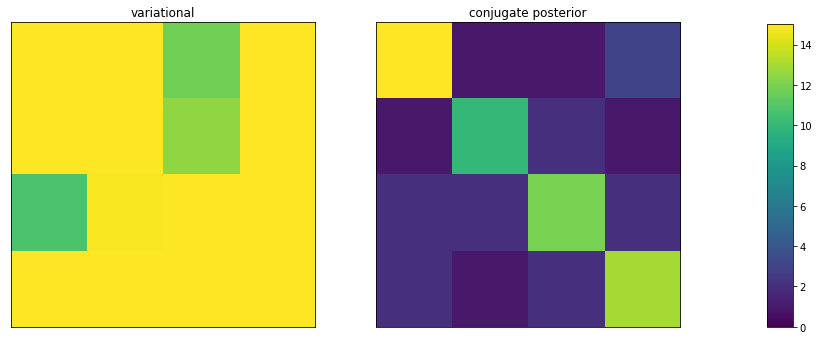

In [7]:
plot_dirs(enc, alpha_trans_0, Z_ret, Zs_true, T, K, num_particles_rws, vmax=15)

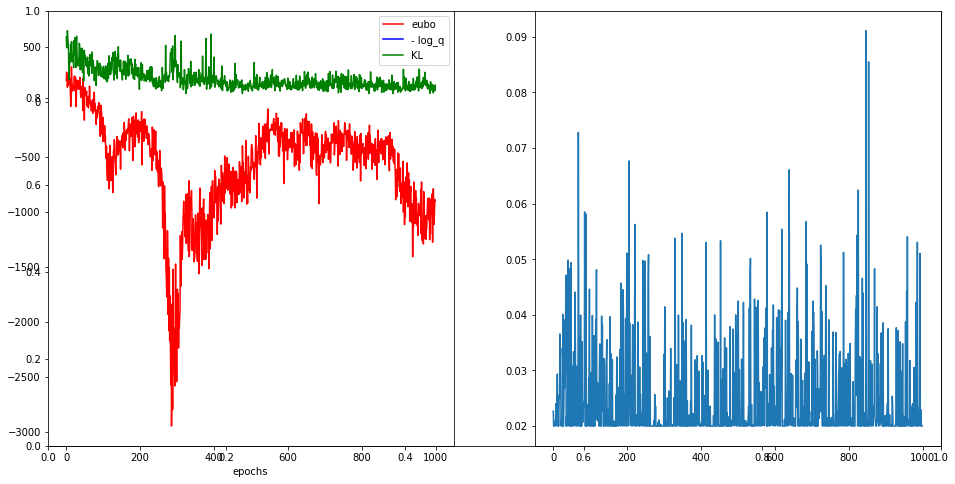

In [8]:
plot_results(EUBOs, log_qs, KLs, ESSs, num_particles_rws)

In [9]:
if RESTORE:
    enc.load_state_dict(torch.load(PATH_ENC))
else:
    torch.save(enc.state_dict(), PATH_ENC)

NameError: name 'radius' is not defined

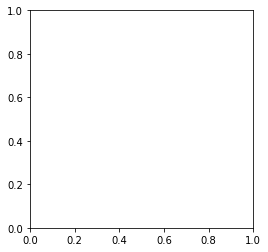

In [10]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(-(Boundary-radius), Boundary-radius)
ax.set_ylim(-(Boundary-radius), Boundary-radius)
# ax.axis('equal')
plot_cov_ellipse(cov=np.eye(2)*210, pos=np.array([0, 0]), nstd=2, ax=ax, alpha=0.5)